1. 시계열의 안정성이 충분히 확인되었는가?
플로팅과 adfuller 메소드가 모두 적절히 사용되었음  
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨  
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# TWTR(트위터)주식 예측
#### STEP 1 : 시계열 데이터 준비

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성

data_1 = os.getenv('HOME') + '/aiffel/stock_prediction/data/TWTR.csv'

os = operating system의 약자로 운영체제이며 파이썬에 기본적으로 내장된 모듈의 이름이다. 이 기능으로 현재 디렉토리 확인하기(getcwd()),디렉토리변경(chdir),현재 디렉토리의 파일 목록확인하기(listdir()), CSV파일 호출 등을 할 수 있다.

In [112]:
df_1 = pd.read_csv(data_1, index_col='Date', parse_dates=True)
tw = df_1['Close']

tw.head()

Date
2021-07-26    68.690002
2021-07-27    68.330002
2021-07-28    69.959999
2021-07-29    70.370003
2021-07-30    69.750000
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행


In [113]:
# 결측치 처리
tw = tw.interpolate(method='time') #interpolate : 결측치 보간하기->time(시간/날짜 간격)으로  보간
tw[tw.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력 


Series([], Name: Close, dtype: float64)

In [114]:
# 로그 변환 시도 
tw_log = np.log(tw)

#### STEP 3 : 시계열 안정성 분석

In [115]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [116]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

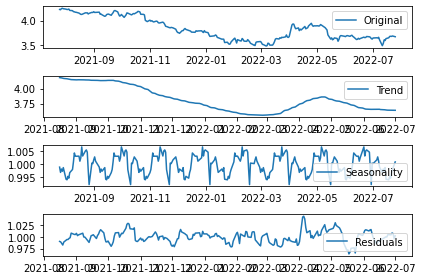

In [117]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tw_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tw_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### 안정 시계열로 변환 하는 이유
- 시계열 분석을 위해서는 시계열 모형을 만들어야 한다. 자료는 우리가 관측한 데이터(우리가 알고있는)이고 모형은 이론적이지만 실제가 아닌 데이터(우리가 모르는)이다.   
- 우리가 모르는 시계열 모형을 만들기 위해서는 데이터의 값이나 확률분포를 수치화해야하는데 데이터의 추세(trend), 계절성(seasonality)이 있으면 시간에 따라 값이나 확률분포의 의미가 달라진다.  
=> 따라서 시계열 분석의 일반적인 경우는 추세, 계절성을 제거해서 분석해야 한다.
 
- AR, MA, ARMA, ARIMA 등 통계적 모델은 과거의 N 시점의 값을 선형회귀에 대한 입력으로 사용하여 N+1을 예측하는 일종의 회귀모형이다. 따라서 확률분포와 같은 통계 값이 시간에 따라 변하지 않아야 한다. 
 
- 다만, RNN, LSTM 과 같은 인공지능 모델은 비선형적 모델이라고 할 수 있기때문에 안정시계열로 변환할 필요가 없다.  
출처: https://domini21.tistory.com/14 [삼십촉 백열등!:티스토리]

In [118]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.105321
p-value                          0.000949
#Lags Used                      10.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


p-value를 확인해 보면 0.00949로 95%이상의 confidence로 안정하다고 할 수 있다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

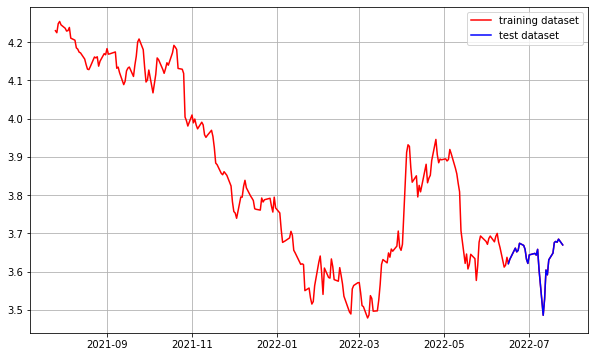

In [119]:
train_data, test_data = tw_log[:int(len(tw_log)*0.9)], tw_log[int(len(tw_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tw_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 tw_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


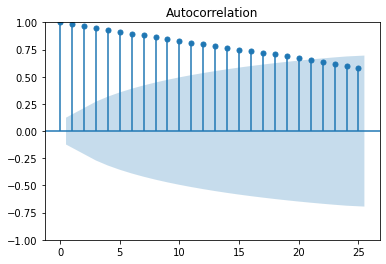

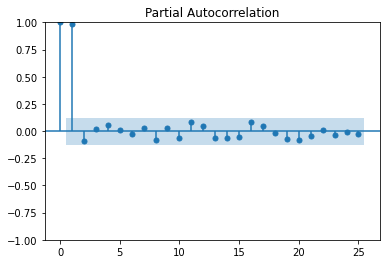

In [120]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tw_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(tw_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### ACF, PACF
- ACF(Autocorrelation): 자기상관함수
- PACF(Partial Autocorrelation Function): 편자기상관함수
- ARIMA 모델의 파라미터가 되는 p,d,q의 최적 차수를 탐색할 때 유용하게 사용

위의 상관도표를 보면 ACF의 절단점은 20이고 PACF는 3이다.

Results of Dickey-Fuller Test:
Test Statistic                -1.400253e+01
p-value                        3.839155e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.408672e+00
p-value                        2.133050e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


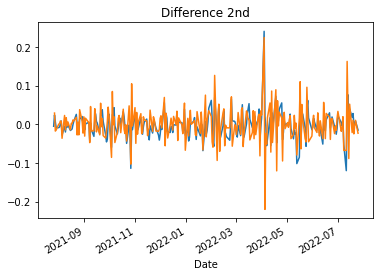

In [121]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = tw_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 차분(differencing) : 시계열을 정상성을 나타내도록 만드는 방법 — 연이은 관측값들의 차이를 계산하는 것이다
- 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는데 도움이 될 수 있어 결과적으로 추세나 계절성이 제거(또는 감소)된다.
- 상관도표를 보면 ACF, PACF가 비정상성을 보여 2차 차분을 통해 정상성을 가지는 시계열을 만들었고 이는 그래프 통해 확인 할 수 있다

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [122]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 452.774
Date:                Wed, 27 Jul 2022   AIC                           -895.548
Time:                        15:00:35   BIC                           -878.446
Sample:                             0   HQIC                          -888.646
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8937      0.156     24.926      0.000       3.588       4.200
ar.L1          1.0018      0.692      1.448      0.148      -0.354       2.358
ar.L2         -0.0120      0.689     -0.017      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


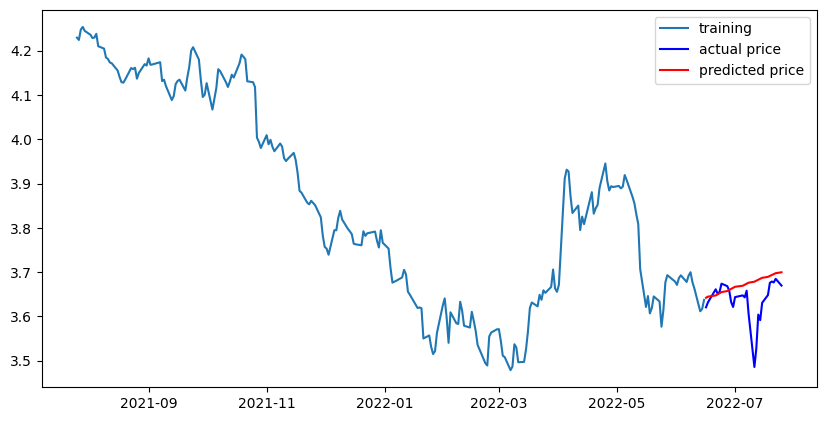

In [123]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 그래프에서 예측값으론 상승곡선을 이루고 있지만 실제값은 떨어졌다 상승하는 곡선을 보인다.  
- 얼마나 정확한 예측을 한 것인지 오차율을 확인해 보는 것이 필요하다

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.924610694477593
MAE:  1.4919058242081265
RMSE:  2.219146388699401
MAPE: 4.12%


# 회고
- 처음 예측해본 주가는 트위터이다.
- 2022년 3월 정도에 급격하게 낮아졌다가 5월에 최고가를 찍고 최근 다시 낮아지는 추세로 보인다.
- 그래프로 확인 했을 때 actual price와 pridect price의 모양의 차이가 난다. 그래도 예측 오차율은 4.12%로 10%보다 낮은 오차율을 보여 나쁘지 않은 최적화 모델을 찾은 것 같다.

# DWAC(디지털 월드 애퀴지션)주식 예측
#### STEP 1 : 시계열 데이터 준비

In [125]:
data_2 = os.getenv('HOME') + '/aiffel/stock_prediction/data/DWAC.csv'

In [126]:
df_2 = pd.read_csv(data_2, index_col='Date', parse_dates=True)
dw = df_2['Close']

dw.head()

Date
2021-09-30    9.950
2021-10-01    9.940
2021-10-04    9.920
2021-10-05    9.928
2021-10-06    9.920
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행

In [127]:
# 결측치 처리
dw = dw.interpolate(method='time')
dw[dw.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [128]:
# 로그 변환 시도 
dw_log = np.log(dw)

#### STEP 3 : 시계열 안정성 분석

In [129]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [130]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

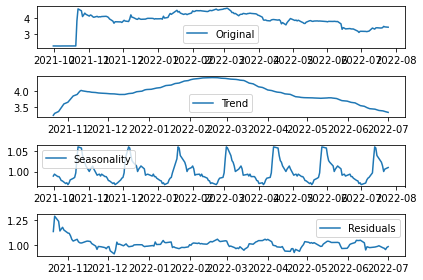

In [131]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dw_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dw_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [132]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.328656e+00
p-value                        2.943274e-08
#Lags Used                     1.000000e+00
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64


#### STEP 4 : 학습, 테스트 데이터셋 생성

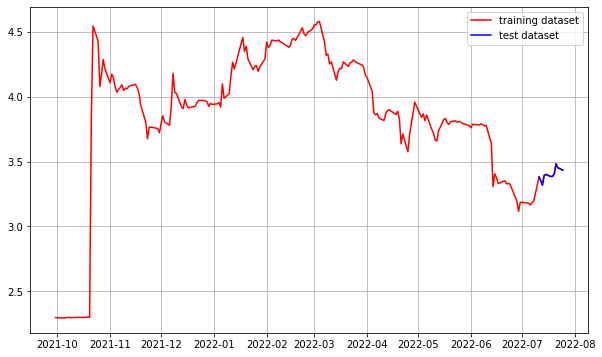

In [133]:
train_data, test_data = dw_log[:int(len(dw_log)*0.95)], dw_log[int(len(dw_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(dw_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 dw_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


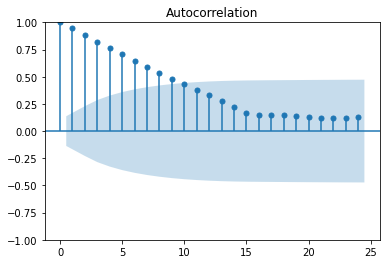

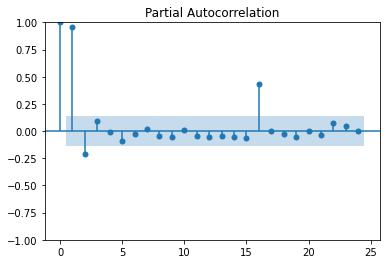

In [134]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dw_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(dw_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.075606e+00
p-value                        1.123550e-07
#Lags Used                     5.000000e+00
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.046071e+01
p-value                        1.361438e-18
#Lags Used                     1.400000e+01
Number of Observations Used    1.880000e+02
Critical Value (1%)           -3.465620e+00
Critical Value (5%)           -2.877040e+00
Critical Value (10%)          -2.575032e+00
dtype: float64


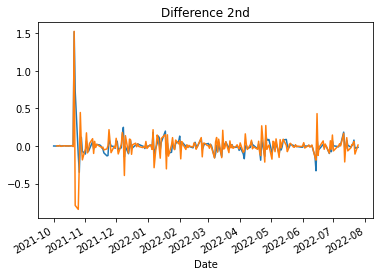

In [135]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = dw_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 두번째 주식예측에서도 상관도표를 보면 ACF, PACF가 비정상성을 보여 2차 차분을 통해 정상성을 가지는 시계열을 만들었고 이는 그래프 통해 확인 할 수 있다

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [136]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  194
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 114.147
Date:                Wed, 27 Jul 2022   AIC                           -218.293
Time:                        15:00:38   BIC                           -201.954
Sample:                             0   HQIC                          -211.677
                                - 194                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6156      0.364      9.921      0.000       2.901       4.330
ar.L1          0.9188      0.199      4.608      0.000       0.528       1.310
ar.L2          0.0428      0.195      0.220      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


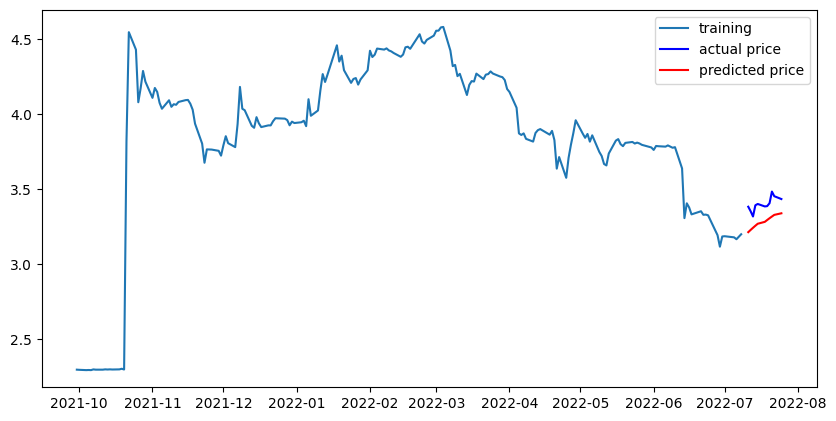

In [137]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.1)  # 90% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12.181829794610074
MAE:  3.387941352669681
RMSE:  3.490247812779212
MAPE: 11.25%


# 회고
- 두번째로 예측해본 주가는 디지털 월드 애퀴지션이다.(조금 생소한 기업이지만 내 지분도 개미만큼있으니(?) 한번 예측을 해보았다)
- 처음 위의 트위터와 같은 수치로 예측했을 때 오차률이 25%로 높게 나왔다.
- 학습, 테스트 데이터 셋에 *0.90을 *0.95로 변경하고 forecast의 ahlpa를 0.05에서 0.1로 변경하였더니 11. % 로 낮아졌다
- 위의 상관도표를 보면 ACF의 절단점은 10이고 PACF는 4이다.

# MTEX(매나테크) 분석
#### STEP1 : 시계열 데이터 분석

In [139]:
data_3 = os.getenv('HOME') + '/aiffel/stock_prediction/data/MTEX.csv'

In [140]:
df_3 = pd.read_csv(data_3, index_col='Date', parse_dates=True)
mt = df_3['Close']

mt.head()

Date
2021-07-26    28.389999
2021-07-27    27.600000
2021-07-28    28.370001
2021-07-29    28.010000
2021-07-30    26.309999
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [141]:
# 결측치 처리
mt = mt.interpolate(method='time')
mt[mt.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [142]:
mt_log = np.log(mt)

#### STEP 3 : 시계열 안정성 분석

In [143]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [144]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


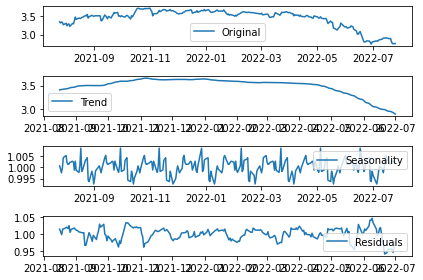

In [145]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mt_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mt_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [146]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.221825e+00
p-value                        2.101666e-10
#Lags Used                     1.100000e+01
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


#### STEP 4 : 학습, 테스트 데이터셋 생성

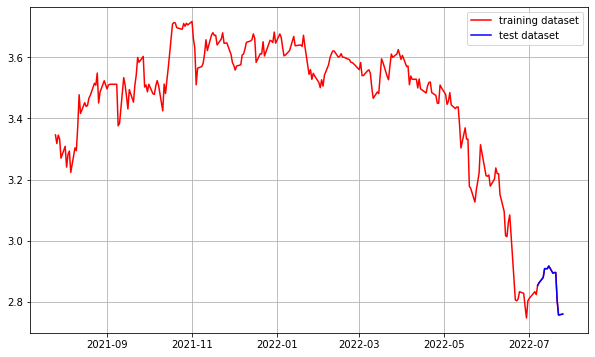

In [147]:
train_data, test_data = mt_log[:int(len(mt_log)*0.95)], mt_log[int(len(mt_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(mt_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 mt_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


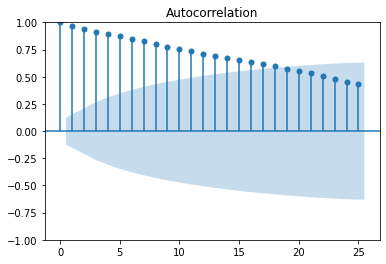

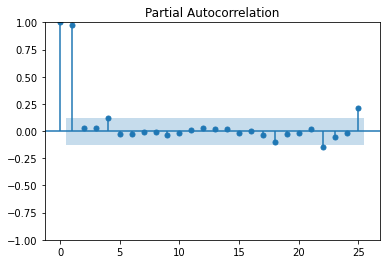

In [148]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mt_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(mt_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.029015e+01
p-value                        3.587761e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.291643e+00
p-value                        1.412158e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


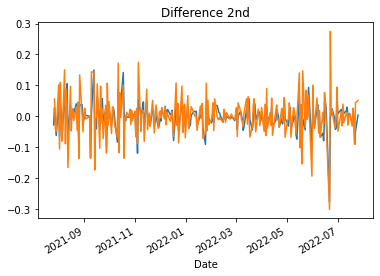

In [149]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = mt_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 위의 상관도표를 보면 ACF, PACF가 비정상성을 보여 2차 차분을 통해 정상성을 가지는 시계열을 만들었고 이는 그래프 통해 확인 할 수 있다

#### STEP 6 : ARIMA 모델 훈련과 테스트

In [150]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  239
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 407.709
Date:                Wed, 27 Jul 2022   AIC                           -805.418
Time:                        15:00:41   BIC                           -788.035
Sample:                             0   HQIC                          -798.413
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3010      0.306     10.800      0.000       2.702       3.900
ar.L1          0.3718      0.407      0.914      0.361      -0.425       1.169
ar.L2          0.6117      0.400      1.530      0.1

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


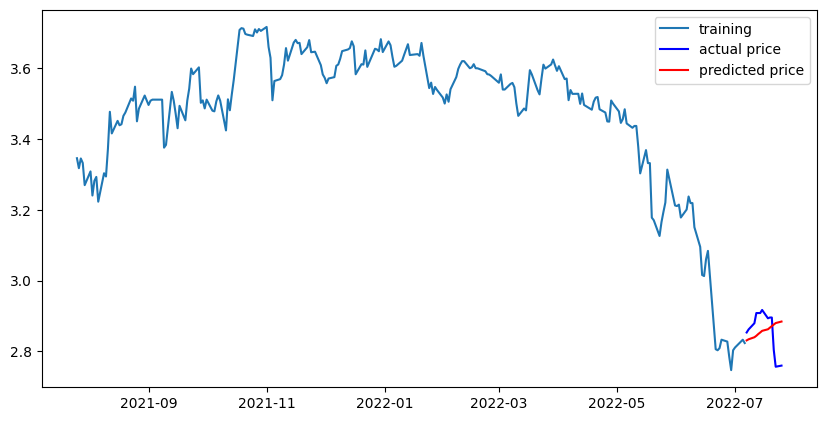

In [151]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.2519026092421524
MAE:  0.9751378147061145
RMSE:  1.1188845379404224
MAPE: 5.69%


# 회고
- 마지막으로 매나테크(건강보조식품)주식에 대해 예측해 보았다
- 마지막 그래프에서 예측값과 실제값의 그래프가 다른 모습을 보이고 있어 오차율에 대해 알아보았다
- 매나테크주식도 트위터주식과 같은 수치로 예측했을 때 오차률이 20%로 높게 나왔다.
- 학습, 테스트 데이터 셋에 *0.90을 *0.95로 변경하였더니 5.69%로 낮은 오차율을 보였다.
- 위의 상관도표를 보면 ACF의 절단점은 10이고 PACF는 4이다.

#### 마무리
시계열 데이터가 충분히 이해되지 않은 상태여서 설명에 대한 글을 읽어보는 것을 반복했다. 시계열에 대한 학습을 보충해주어야겠다. 지금까지 이해한 내용을 바탕으로 최대한 예측해보고 데이터를 분석해보았다. 평소 관심을 가졌던 주식에 대해 예측을 해보면서 더 흥미로운 Exploration이 되었던것 같다.